In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
from itertools import product

import pandas as pd

from scipy.special import roots_chebyt

pd.set_option('display.float_format', lambda x: '%.5f' % x)

# wzór Hermite'a
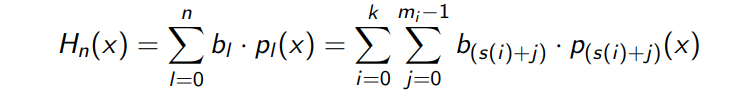

# Zadana funkcja
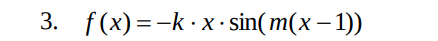
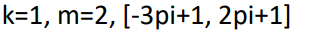

## Wykresy sporządzone w dalszej części programu, pokazują wyniki interpolacji funkcji metodą Hermite'a uwzględniając pochodne funkcji. 
## Rysowanie wykresów było na podstawie 1000 równoodległych punktów z przedziału a, b  -  (-3pi+1, 2pi+1), a węzły interpolacji są wyznaczane równoodlegle oraz na podstawie zer wielomianu Czebyszewa dla n z zakresu od 3 do 40.
## Wyniki zostały opracowane w oparciu o dwie metryki, SSE oraz metrykę maksymalnego błędu.
## 

In [2]:
k = 1
m = 2
def f(x):
    return -k * x * math.sin(m*(x-1))
f = np.vectorize(f)

def df(x):
    return -k*m*math.cos(m*(x-1)) * x - k* math.sin(m*(x-1))
df = np.vectorize(df)


def ddf(x):
    return -k*(m*math.cos(m*(x-1)) * x + math.sin(m*(x-1)))
ddf = np.vectorize(ddf)

a = -3 * math.pi + 1
b = 2 * math.pi + 1

x_space = np.linspace(a, b, 1000)

### interpolacja Hermite'a 

In [3]:
X = np.linspace(a, b, 1000)

# define data before using H(x)
def H(x):
    n = sum([len(node) for node in data])

    B = [[None for _ in range(n)] for i in range(n)]

    helper = []
    for row in data:
        for _ in range(len(row)):
            helper.append(row[0])
    idx_helper = []
    for i, row in enumerate(data):
        for _ in range(len(row)):
            idx_helper.append(i)
    
    cnt = 0
    for i in range(len(data)):
        for j in range(len(data[i])):
            B[cnt][0] = f(data[i][0])
            cnt += 1
    
    for i in range(1, n):
        for j in range(1, i+1):
            # if has derivative                
            if data[idx_helper[i]] == data[idx_helper[i-j]] and j < len(data[idx_helper[i]]):
                B[i][j] = data[idx_helper[i]][j] / math.factorial(j)
            else:
                B[i][j] = (B[i][j-1] - B[i-1][j-1]) / (helper[i] - helper[i-j])
        
    
    def p(i, x):
        if i == 0: return 1
        result = 1
        idx = 0
        counter = 0
        while counter < i:
            for _ in range(len(data[idx])):
                if counter >= i: break
                result *= (x - data[idx][0])
                counter += 1
            idx += 1

        return result        
    
    return sum([B[i][i] * p(i, x) for i in range(n)])

### funkcja do rysowania wykresu

In [4]:
def plot(space, *functions, points=False, title=False):
    if points != False:
        plt.scatter(points[0], points[1], label="nodes")
    
    for foo, lbl in functions:   
        plt.plot(space, foo(space), label=lbl)
    
    if title:    
        plt.title(title)
        
    plt.rcParams['figure.figsize'] = [10, 7]
    plt.legend()
    plt.grid()
    plt.show()

## funkcje do wyznaczania danych oraz metryki dokładności

In [5]:
def equidistant(a, b, n):
    x = np.linspace(a, b, n)
    return list(x)

In [6]:
def chebyshev(a, b, n):
    x, weights = roots_chebyt(n)
    scale = abs(a-b) / 2
    shift = (b+a) / 2
    x *= scale
    x += shift
    return x

In [7]:
def diff_SSE(X1, X2):
    return sum([(X1[i] - X2[i]) ** 2 for i in range(len(X1))])

In [8]:
def diff_max(X1, X2):
    return max([abs(X1[i] - X2[i]) for i in range(len(X1))])

# Wyznaczanie dokładności interpolowanej funkcji

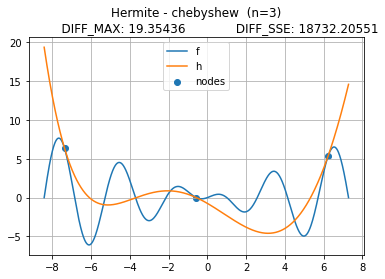

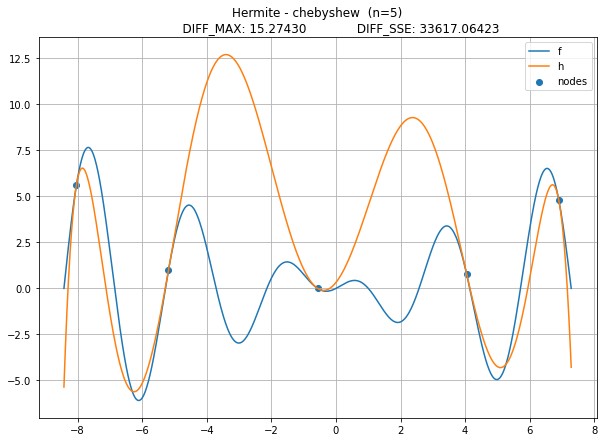

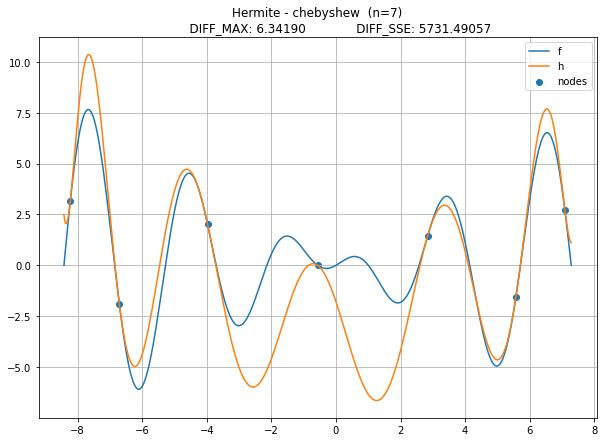

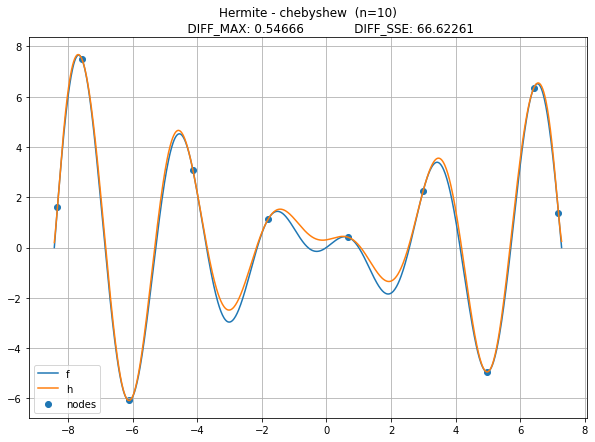

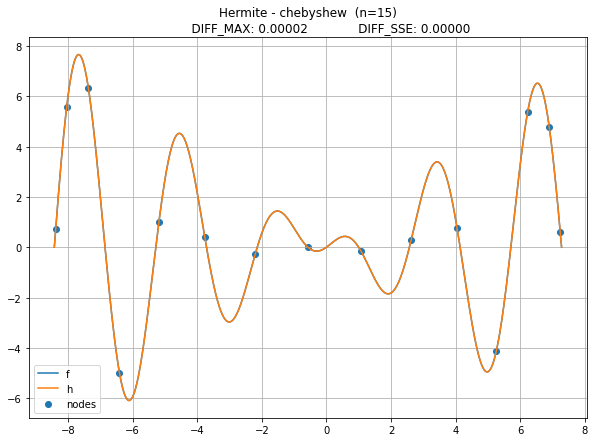

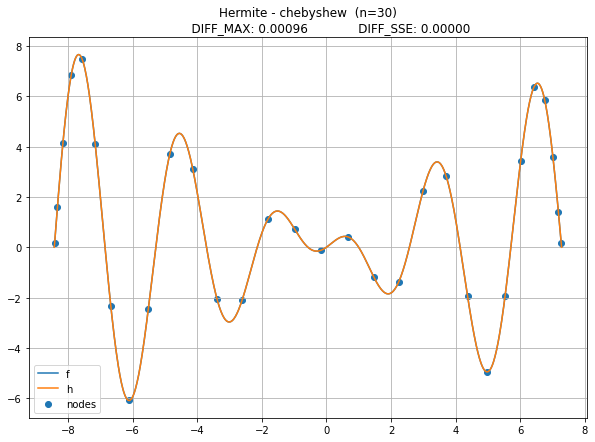

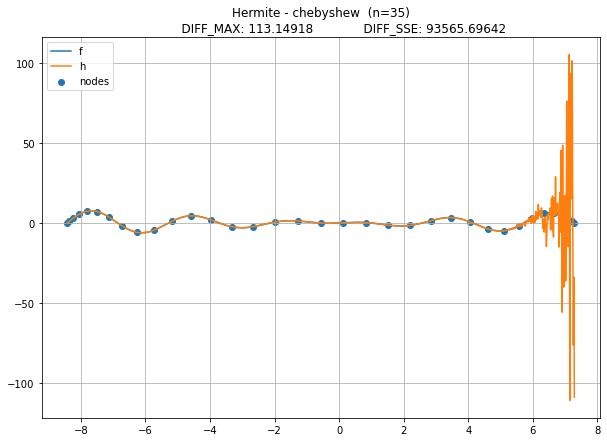

In [9]:
dataframe = pd.DataFrame(columns=["n", "SSE", "MAX"])

for i in [3,5,7,10,15,30,35]:
    data = chebyshev(a,b, i)
    pts = data[:]
    data = [[x, df(x)] for x in data]
    
    cheb = H(x_space)
    dsse = diff_SSE(cheb, f(x_space))
    dmax = diff_max(cheb, f(x_space))
    dataframe.loc[len(dataframe.index)] = [i, dsse, dmax]
    
    plot(x_space, [f, 'f'], [H, 'h'], 
        points=[pts, f(pts)],
        title=f"Hermite - chebyshew  (n={i})\n\
            DIFF_MAX: {dmax:.5f} \
            DIFF_SSE: {dsse:.5f}")

# Dokładność funkcji interpolowanej wzorem Hermite'a dla n węzłów rozmieszczonych zgodnie z zerami wielomianu Czebyszewa

In [10]:
dataframe

,n,SSE,MAX
0,3.00000,18732.20551,19.35436
1,5.00000,33617.06423,15.27430
2,7.00000,5731.49057,6.34190
3,10.00000,66.62261,0.54666
4,15.00000,0.00000,0.00002
5,30.00000,0.00000,0.00096
6,35.00000,93565.69642,113.14918


### najlepsze wyniki daje funkcja interpolowana dla ok 20 węzłów, dla ilości większej niż około 35, funkcja zaczyna znacząco odbiegać od interpolowanej
# 


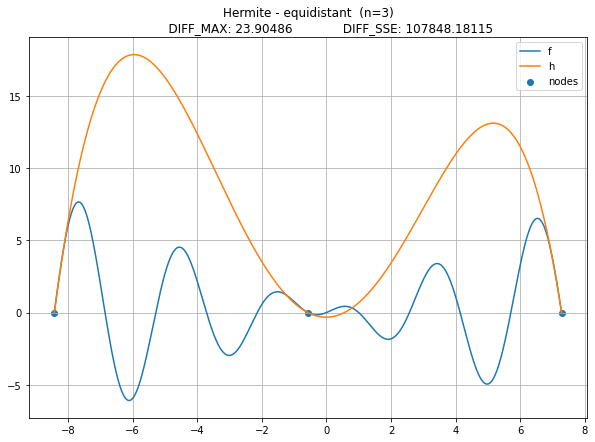

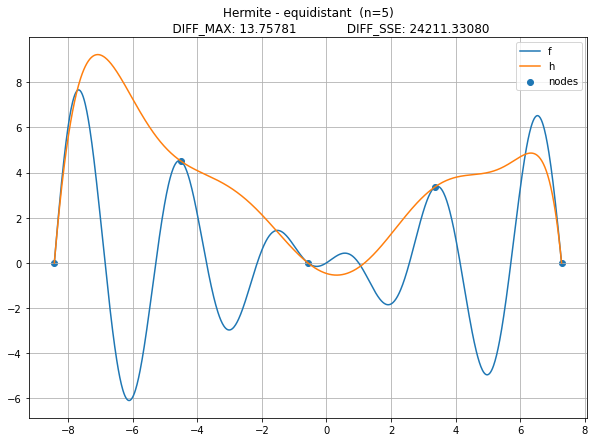

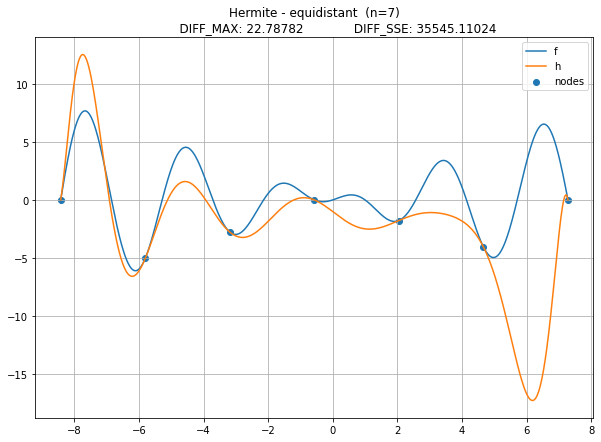

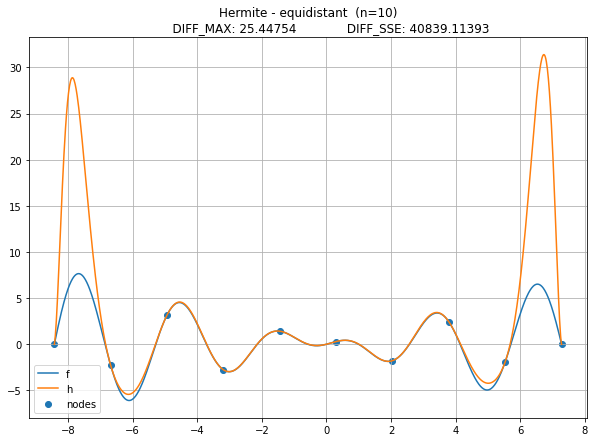

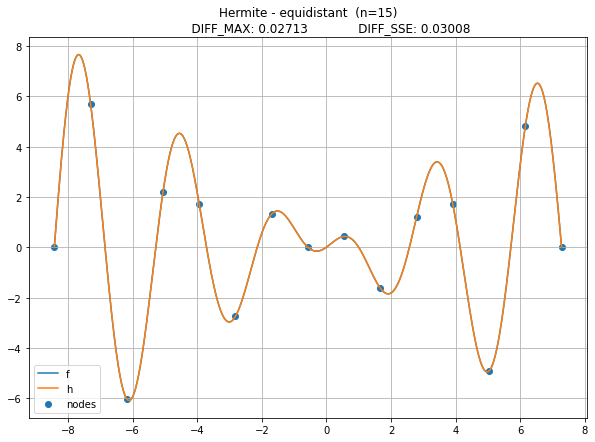

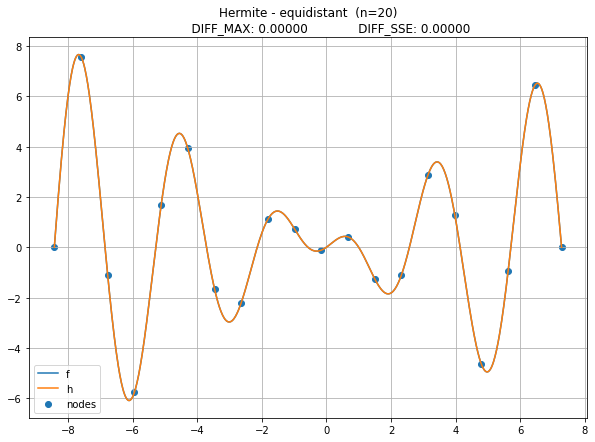

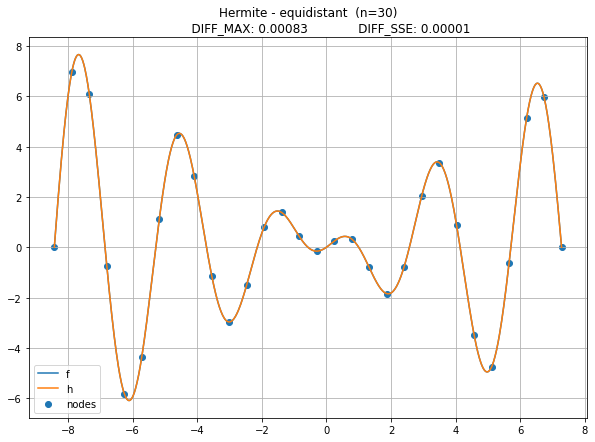

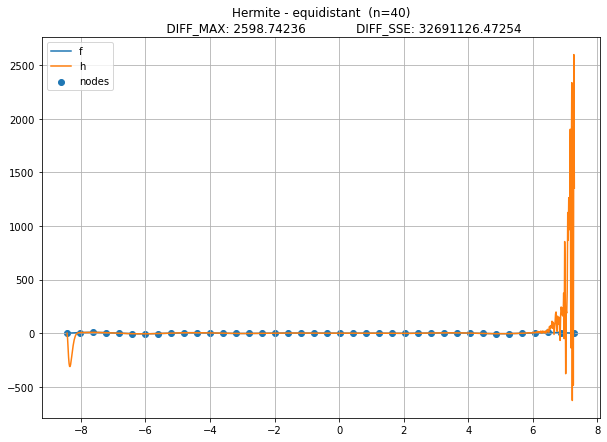

In [11]:
dataframe = pd.DataFrame(columns=["n", "SSE", "MAX"])

for i in [3,5,7,10,15, 20,30, 40]:
    data = equidistant(a,b, i)
    pts = data[:]
    data = [[x, df(x)] for x in data]
    
    equi = H(x_space)
    dsse = diff_SSE(equi, f(x_space))
    dmax = diff_max(equi, f(x_space))
    dataframe.loc[len(dataframe.index)] = [i, dsse, dmax]
    
    plot(x_space, [f, 'f'], [H, 'h'], 
        points=[pts, [f(x) for x in pts]],
        title=f"Hermite - equidistant  (n={i})\n\
            DIFF_MAX: {dmax:.5f} \
            DIFF_SSE: {dsse:.5f}")

# Dokładność funkcji interpolowanej wzorem Hermite'a dla n węzłów rozmieszczonych równoodlegle 

In [12]:
dataframe

,n,SSE,MAX
0,3.00000,107848.18115,23.90486
1,5.00000,24211.33080,13.75781
2,7.00000,35545.11024,22.78782
3,10.00000,40839.11393,25.44754
4,15.00000,0.03008,0.02713
5,20.00000,0.00000,0.00000
6,30.00000,0.00001,0.00083
7,40.00000,32691126.47254,2598.74236


### podobnie jak w przypadku węzłów rozmieszczonych zgodnie z zerami wielomianu Czebyszewa, najdokładniejszą interpolacje otrzymujemy dla ok 20 węzłów, od ok 40 wezłów funkcja zaczyna znacząco rozbiegać od f(x)
### dla `n` równego ok 10 możemy zauważyć efekt Rungego 
# 